<a href="https://colab.research.google.com/github/msoley/CSCI-535/blob/main/reddit_mental_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Steps to install packages and download data/model

In [1]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="JeremiahZ/reddit", filename="reddit.zip", local_dir=".", repo_type="dataset")
# unzip the zip file
!unzip reddit.zip
!rm -rf reddit.zip

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


reddit.zip:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

Archive:  reddit.zip
   creating: data/
  inflating: data/guns_pre_features_tfidf_256.csv  
  inflating: data/relationships_2018_features_tfidf_256.csv  
  inflating: data/socialanxiety_post_features_tfidf_256.csv  
  inflating: data/adhd_2018_features_tfidf_256.csv  
  inflating: data/autism_2019_features_tfidf_256.csv  
  inflating: data/teaching_post_features_tfidf_256.csv  
  inflating: data/ptsd_2018_features_tfidf_256.csv  
  inflating: data/suicidewatch_pre_features_tfidf_256.csv  
  inflating: data/autism_post_features_tfidf_256.csv  
  inflating: data/socialanxiety_2019_features_tfidf_256.csv  
  inflating: data/lonely_2018_features_tfidf_256.csv  
  inflating: data/teaching_2019_features_tfidf_256.csv  
  inflating: data/mentalhealth_pre_features_tfidf_256.csv  
  inflating: data/legaladvice_2018_features_tfidf_256.csv  
  inflating: data/lonely_pre_features_tfidf_256.csv  
  inflating: data/alcoholism_pre_features_tfidf_256.csv  
  inflating: data/bipolarreddit_2019_features

In [2]:
hf_hub_download(repo_id="JeremiahZ/reddit_lda", filename="lda_model.zip", local_dir=".", )
# unzip the zip file
!unzip lda_model.zip
!rm -rf lda_model.zip

lda_model.zip:   0%|          | 0.00/2.08M [00:00<?, ?B/s]

Archive:  lda_model.zip
   creating: output/lda_models/
  inflating: output/lda_models/model_pre_10.state  
  inflating: output/lda_models/model_pre_10  
  inflating: output/lda_models/model_pre_10.expElogbeta.npy  
  inflating: output/lda_models/model_pre_10.id2word  


In [3]:
import os
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models import Phrases
from gensim.test.utils import datapath
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
nltk.download('wordnet')
stemmer = SnowballStemmer(language='english')

[nltk_data] Downloading package wordnet to /root/nltk_data...


## Extract out documents from Pre-Pandemic Data and Pre-Process

Procedure adapted from: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [4]:
'''
We extract out a sampling of posts from pre- and mid-pandemic mental health subreddits.
These are stemmed and lemmatized. They are then made into a dictionary and are used
to create a bag of words corpus. This corpus and dictionary are used to form the LDA model.

'''

data_folder = './data/'
output_path = "./data/output/"

pre_pandemic = True

pre_files = ['suicidewatch_pre_features_tfidf_256.csv',
        'depression_pre_features_tfidf_256.csv',
        'ptsd_pre_features_tfidf_256.csv',
        'anxiety_pre_features_tfidf_256.csv',
        'socialanxiety_pre_features_tfidf_256.csv',
        'bipolarreddit_pre_features_tfidf_256.csv',
        'bpd_pre_features_tfidf_256.csv',
        'schizophrenia_pre_features_tfidf_256.csv',
        'EDAnonymous_pre_features_tfidf_256.csv',
        'alcoholism_pre_features_tfidf_256.csv',
        'addiction_pre_features_tfidf_256.csv',
        'adhd_pre_features_tfidf_256.csv',
        'autism_pre_features_tfidf_256.csv',
        'lonely_pre_features_tfidf_256.csv']

mid_files = ['suicidewatch_post_features_tfidf_256.csv',
        'depression_post_features_tfidf_256.csv',
        'ptsd_post_features_tfidf_256.csv',
        'anxiety_post_features_tfidf_256.csv',
        'socialanxiety_post_features_tfidf_256.csv',
        'bipolarreddit_post_features_tfidf_256.csv',
        'bpd_post_features_tfidf_256.csv',
        'schizophrenia_post_features_tfidf_256.csv',
        'EDAnonymous_post_features_tfidf_256.csv',
        'alcoholism_post_features_tfidf_256.csv',
        'addiction_post_features_tfidf_256.csv',
        'adhd_post_features_tfidf_256.csv',
        'autism_post_features_tfidf_256.csv',
        'lonely_post_features_tfidf_256.csv']


pre_sample = 2700
mid_sample = 1300
sample = pre_sample if pre_pandemic else mid_sample
files = pre_files if pre_pandemic else mid_files

# can use these dates for generating the mid-pandemic model with the acute phase of the pandemic
# to use, uncomment date lines below
beg_date = datetime.datetime(2020, 3, 16)
end_date = datetime.datetime(2020, 4, 20)

health_anxiety_file = 'healthanxiety_pre_features_tfidf_256.csv' if pre_pandemic else 'healthanxiety_post_features_tfidf_256.csv'

data = pd.read_csv(os.path.join(data_folder, health_anxiety_file))
data = data.sample(sample)
# data['date'] = pd.to_datetime(data['date'], format="%Y/%m/%d")
# data = data.loc[(data['date'] >= beg_date)]
# data =  data.loc[(data['date'] < end_date)]
data_text = data.loc[:,['post']]

for file in files:
    data = pd.read_csv(os.path.join(data_folder, file));
    data = data.sample(sample)
#     data['date'] = pd.to_datetime(data['date'], format="%Y/%m/%d")
#     data = data.loc[(data['date'] >= beg_date)]
#     data =  data.loc[(data['date'] < end_date)]
    data_text = pd.concat([data_text, data.loc[:,['post']]], axis=0, ignore_index=True)
data_text['index'] = data_text.index

In [5]:
documents = data_text
# Look at shape of documents and a sample post
print(documents.shape)
# print(documents.iloc[20][0])

(40500, 2)


In [6]:
# Methods for stemming and lemmatizing all posts
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [7]:
# Preprocess all documents to stem and lemmatize the words
processed_docs = documents['post'].map(preprocess)
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(processed_docs, min_count=20)
for idx in range(len(processed_docs)):
    for token in bigram[processed_docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            processed_docs[idx].append(token)

In [8]:
# Use processed documents to create a dictionary of unigrams and bigrams. Filter to include only top 100k.
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=0.001, no_above=0.5, keep_n=100000)

## Let's look at most common Unigrams and Bigrams

In [9]:
print("Unigrams:\n")
count=0
for k, v in dictionary.iteritems():
    if '_' in v:
      continue
    print(k, v)
    count += 1
    if count > 10:
        break

Unigrams:

0 afternoon
1 albuterol
2 asthma
3 experi
4 fine
5 have
6 heart
8 inhal
9 long
10 normal
11 origin


In [10]:
print("Bigrams:\n")
count=0
for k, v in dictionary.iteritems():
    if '_' not in v:
      continue
    print(k, v)
    count += 1
    if count > 10:
        break

Bigrams:

7 heart_palpit
49 seek_reassur
53 stick_loop
60 anxieti_roof
81 famili_member
83 fast_forward
92 health_anxieti
119 quit_smoke
128 rural_area
134 smoke_weed
143 swell_lymph


In [11]:
# Transform all processed documents into bag of words format based on dictionary.
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## Create and Save LDA Model
To save time, we are going to load the pre-computed LDA model that is trained on pre-pandemic mental health related reddits

In [12]:
# Create LDA model and print out topics
# lda_model = gensim.models.LdaMulticore(corpus=bow_corpus, num_topics=10, id2word=dictionary, passes=25, workers=3)

# for idx, topic in lda_model.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

In [13]:
# Process a sample document to see the topics that are contained in that document
# print(processed_docs[5000])

# for index, score in sorted(lda_model[bow_corpus[3]], key=lambda tup: -1*tup[1]):
#     print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [14]:
output_path = f"{os.getcwd()}"
output_path = os.path.join(output_path, 'output')
lda_output_path = os.path.join(output_path, 'lda_models')
model_name = "model_pre_10"
model_path_name = datapath(os.path.join(lda_output_path, model_name))
# os.makedirs(lda_output_path, exist_ok=True)

# Save model to disk.
# lda_model.save(model_path_name)

# Load a pretrained model from disk.
lda_model = gensim.models.LdaMulticore.load(model_path_name)
dictionary = gensim.corpora.Dictionary.load(os.path.join(lda_output_path, "{}.id2word".format(model_name)))

In [15]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.045*"feel" + 0.026*"want" + 0.025*"life" + 0.021*"know" + 0.013*"think" + 0.013*"time" + 0.012*"love" + 0.011*"thing" + 0.011*"fuck" + 0.011*"year"
Topic: 1 
Words: 0.040*"friend" + 0.032*"feel" + 0.029*"peopl" + 0.025*"talk" + 0.023*"know" + 0.020*"want" + 0.016*"think" + 0.014*"time" + 0.010*"tell" + 0.010*"thing"
Topic: 2 
Words: 0.015*"help" + 0.015*"peopl" + 0.014*"autism" + 0.013*"know" + 0.012*"think" + 0.010*"thing" + 0.009*"diagnos" + 0.008*"experi" + 0.008*"autist" + 0.007*"mental"
Topic: 3 
Words: 0.090*"anxieti" + 0.039*"ptsd" + 0.030*"help" + 0.024*"social" + 0.023*"social_anxieti" + 0.020*"depress" + 0.019*"trigger" + 0.019*"therapi" + 0.017*"trauma" + 0.016*"wish"
Topic: 4 
Words: 0.023*"work" + 0.021*"school" + 0.013*"time" + 0.011*"go" + 0.011*"year" + 0.011*"eat" + 0.010*"weight" + 0.009*"food" + 0.009*"class" + 0.009*"start"
Topic: 5 
Words: 0.013*"go" + 0.013*"tell" + 0.013*"say" + 0.012*"time" + 0.011*"know" + 0.011*"think" + 0.009*"thing" + 0.00

## Apply LDA Model to all data

Use LDA model created above - apply to all data and create a heatmap.

In [16]:
# labels of LDA topics, depending on the model you have chosen
pre_topics = ['Autism/ADHD + \nSchool/Work', 'Alcohol/Addiction', 'Sleep Issues',
              'Alcohol/Eating Disorders', 'Social Interaction', 'Schizophrenia',
              'Medical/Medication', 'Health Anxiety', 'Mental Health Help', 'Life']

mid_topics = ['Health Anxiety', 'Autism/Social', 'ADHD/Diagnosis',
                             'Work/School/Home', 'Eating Disorder', 'Alcohol/Addiction',
                             'Family', 'Sleep Issues', 'Social/Life', 'Mental Health/PTSD']

distribution_output_path = os.path.join(output_path, 'lda_distribution')

num_topics = 10

Create heatmap and run LDA model on all pre-pandemic mental health posts

In [17]:
files = ['suicidewatch_pre_features_tfidf_256.csv',
        'depression_pre_features_tfidf_256.csv',
        'ptsd_pre_features_tfidf_256.csv',
        'anxiety_pre_features_tfidf_256.csv',
        'socialanxiety_pre_features_tfidf_256.csv',
        'healthanxiety_pre_features_tfidf_256.csv',
        'bipolarreddit_pre_features_tfidf_256.csv',
        'bpd_pre_features_tfidf_256.csv',
        'schizophrenia_pre_features_tfidf_256.csv',
        'EDAnonymous_pre_features_tfidf_256.csv',
        'alcoholism_pre_features_tfidf_256.csv',
        'addiction_pre_features_tfidf_256.csv',
        'adhd_pre_features_tfidf_256.csv',
         'autism_pre_features_tfidf_256.csv',
         'lonely_pre_features_tfidf_256.csv',
        'mentalhealth_pre_features_tfidf_256.csv'
        ]

pre_mental_df = pd.DataFrame(columns=range(num_topics))

for file in files:
  df = pd.read_csv(os.path.join(data_folder, file)).sample(1000);
  posts = df.post
  posts = [dictionary.doc2bow(preprocess(post)) for post in posts]
  scores = np.zeros(shape=num_topics)
  for post in posts:
    topics = lda_model[post]
    for index, score in topics:
      scores[index] += score
  scores /= len(posts)
  # Add a new row at index k with values provided in list
  pre_mental_df.loc[os.path.splitext(file)[0]] = scores.tolist()

os.makedirs(distribution_output_path, exist_ok=True)
# pre_mental_df.to_csv(os.path.join(distribution_output_path, 'pre_mentalhealth_distribution.csv'))

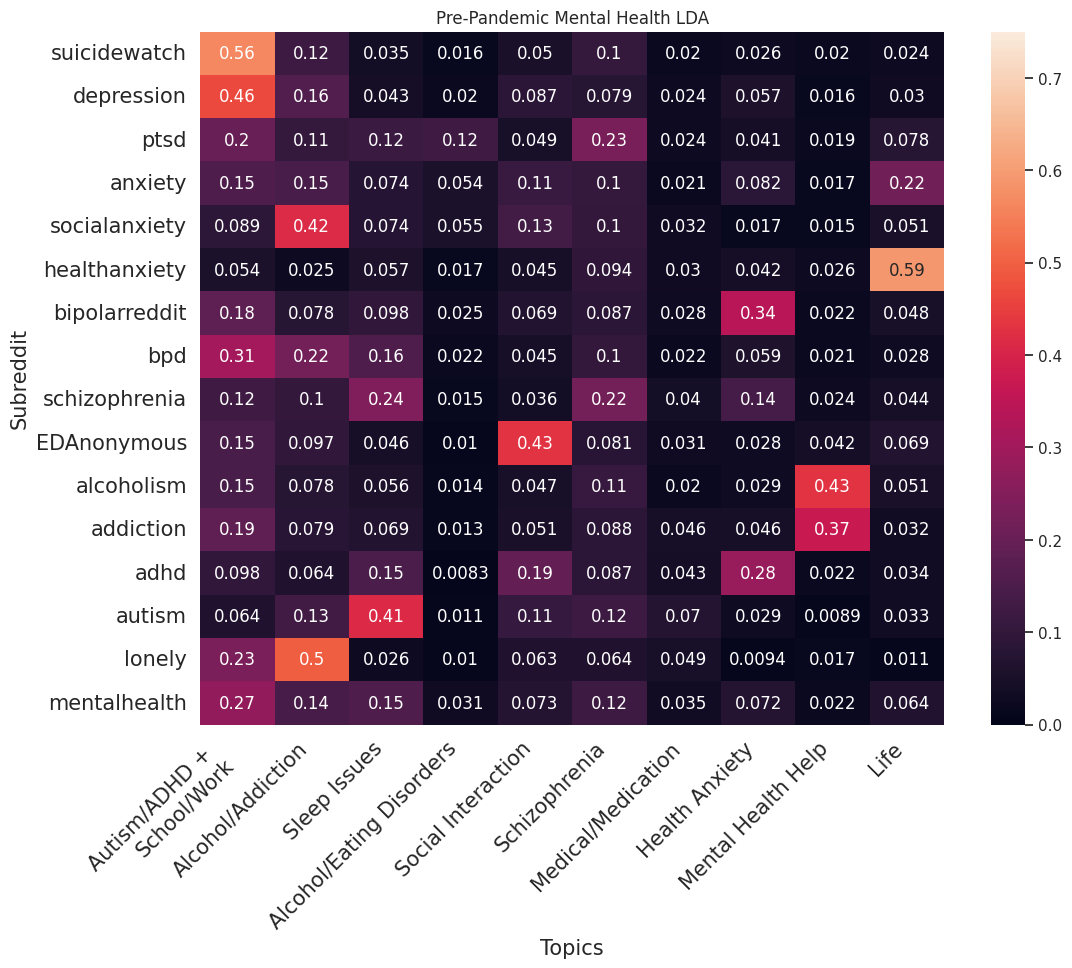

In [18]:
plt.figure(figsize=(12, 9))
ylabels = [file.split('_')[0] for file in files]
sns.set(style='white', font_scale=1, palette=sns.color_palette("husl",15))
chart = sns.heatmap(pre_mental_df, vmin=0, vmax=0.75, annot=True, xticklabels=pre_topics, yticklabels=ylabels)
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=15

)
chart.set_yticklabels(
    chart.get_yticklabels(),
    fontsize=15

)
plt.title('Pre-Pandemic Mental Health LDA')
plt.xlabel('Topics', fontsize=15)
plt.ylabel('Subreddit', fontsize=15)
# plt.savefig(os.path.join(distribution_output_path, 'pre_mentalhealth.png'),
#             format='png', dpi=400, bbox_inches='tight')
plt.show()

## Sentiment Analysis for pre- and mid-pandemic posts

In [19]:
# Download the lexicon
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Example
sentence = "VADER is pretty good at identifying the underlying sentiment of a text!"
print(sent_analyzer.polarity_scores(sentence))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


{'neg': 0.0, 'neu': 0.585, 'pos': 0.415, 'compound': 0.75}


## The **compound** score directly reflects the emotion
Let's compute scores over all reddits to see if pandemic is causing negative emotions on the whole

In [35]:
files = ['suicidewatch_pre_features_tfidf_256.csv',
        'depression_pre_features_tfidf_256.csv',
        'ptsd_pre_features_tfidf_256.csv',
        'anxiety_pre_features_tfidf_256.csv',
        'socialanxiety_pre_features_tfidf_256.csv',
        'healthanxiety_pre_features_tfidf_256.csv',
        'bipolarreddit_pre_features_tfidf_256.csv',
        'bpd_pre_features_tfidf_256.csv',
        'schizophrenia_pre_features_tfidf_256.csv',
        'EDAnonymous_pre_features_tfidf_256.csv',
        'alcoholism_pre_features_tfidf_256.csv',
        'addiction_pre_features_tfidf_256.csv',
        'adhd_pre_features_tfidf_256.csv',
         'autism_pre_features_tfidf_256.csv',
         'lonely_pre_features_tfidf_256.csv',
        'mentalhealth_pre_features_tfidf_256.csv'
        ]

def get_sentiment_score(file_name:str):
  df = pd.read_csv(os.path.join(data_folder, file)).sample(100)
  posts = df.post
  scores = [sent_analyzer.polarity_scores(post) for post in posts]
  return scores
pre_scores ={}
for filename in files:
    pre_scores[filename.split('_')[0]] = get_sentiment_score(filename)

Create heatmap and run LDA model on all mid-pandemic mental health posts

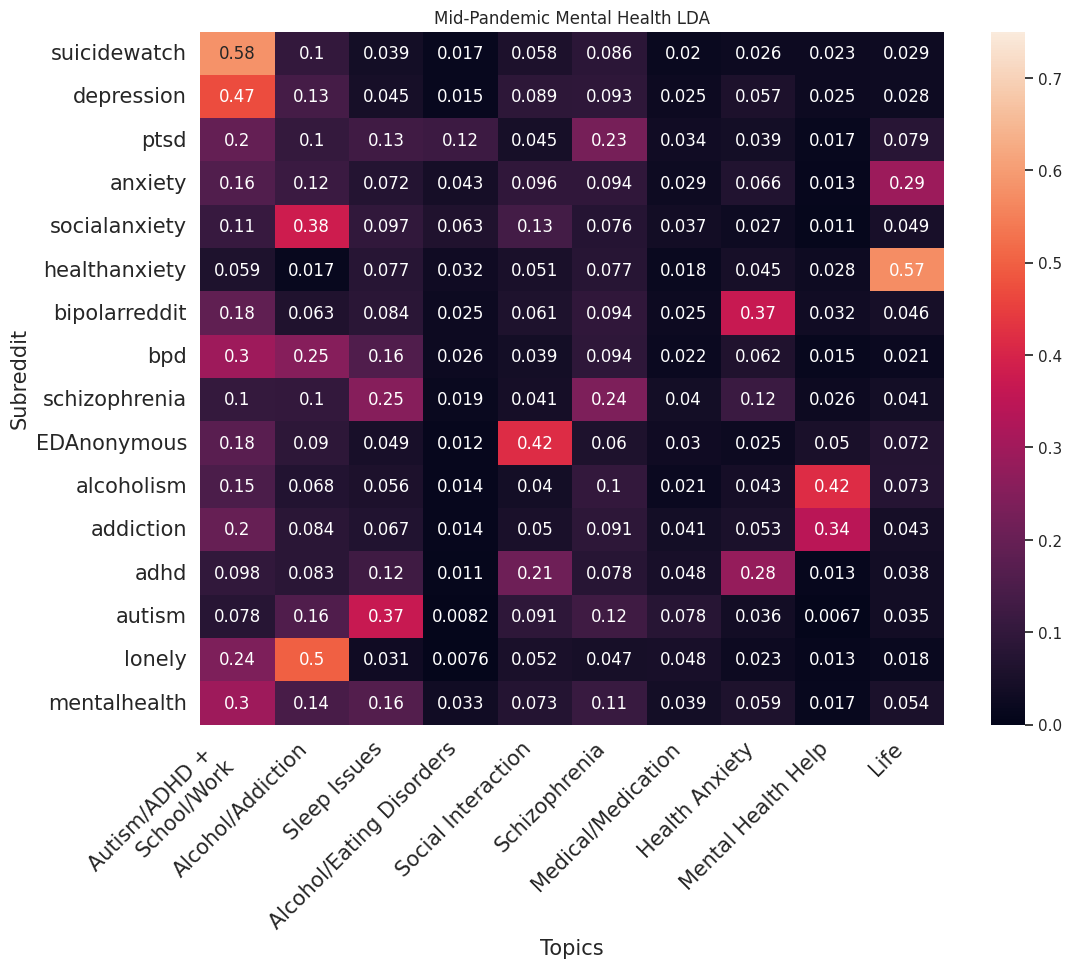

In [21]:
files = ['suicidewatch_post_features_tfidf_256.csv',
        'depression_post_features_tfidf_256.csv',
        'ptsd_post_features_tfidf_256.csv',
        'anxiety_post_features_tfidf_256.csv',
        'socialanxiety_post_features_tfidf_256.csv',
        'healthanxiety_post_features_tfidf_256.csv',
        'bipolarreddit_post_features_tfidf_256.csv',
        'bpd_post_features_tfidf_256.csv',
        'schizophrenia_post_features_tfidf_256.csv',
        'EDAnonymous_post_features_tfidf_256.csv',
        'alcoholism_post_features_tfidf_256.csv',
        'addiction_post_features_tfidf_256.csv',
        'adhd_post_features_tfidf_256.csv',
         'autism_post_features_tfidf_256.csv',
         'lonely_post_features_tfidf_256.csv',
        'mentalhealth_post_features_tfidf_256.csv'
        ]

mid_mental_df = pd.DataFrame(columns=range(num_topics))
beg_date = datetime.datetime(2020, 3, 16)

for file in files:
  df = pd.read_csv(os.path.join(data_folder, file)).sample(1000);
  df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")
  df_mid = df.loc[df['date'] >= beg_date]
  posts = df_mid.post
  posts = [dictionary.doc2bow(preprocess(post)) for post in posts]
  scores = np.zeros(shape=num_topics)
  for post in posts:
    topics = lda_model[post]
    for index, score in topics:
      scores[index] += score
  scores /= len(posts)
  # Add a new row at index k with values provided in list
  mid_mental_df.loc[os.path.splitext(file)[0]] = scores.tolist()

mid_mental_df.to_csv(os.path.join(distribution_output_path, 'mid_mentalhealth_distribution.csv'))

plt.figure(figsize=(12, 9))
ylabels = [file.split('_')[0] for file in files]
sns.set(style='white', font_scale=1, palette=sns.color_palette("husl",15))
chart = sns.heatmap(mid_mental_df, vmin=0, vmax=0.75, annot=True,
                    xticklabels=pre_topics, yticklabels=ylabels)
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=15

)
chart.set_yticklabels(
    chart.get_yticklabels(),
    fontsize=15

)
plt.title('Mid-Pandemic Mental Health LDA')
plt.xlabel('Topics', fontsize=15)
plt.ylabel('Subreddit', fontsize=15)
# plt.savefig(os.path.join(distribution_output_path, 'mid_mentalhealth.png'),
#             format='png', dpi=400, bbox_inches='tight')
plt.show()

## Let's also compute emotion scores on post mid-pandemic

In [39]:
files = ['suicidewatch_post_features_tfidf_256.csv',
        'depression_post_features_tfidf_256.csv',
        'ptsd_post_features_tfidf_256.csv',
        'anxiety_post_features_tfidf_256.csv',
        'socialanxiety_post_features_tfidf_256.csv',
        'healthanxiety_post_features_tfidf_256.csv',
        'bipolarreddit_post_features_tfidf_256.csv',
        'bpd_post_features_tfidf_256.csv',
        'schizophrenia_post_features_tfidf_256.csv',
        'EDAnonymous_post_features_tfidf_256.csv',
        'alcoholism_post_features_tfidf_256.csv',
        'addiction_post_features_tfidf_256.csv',
        'adhd_post_features_tfidf_256.csv',
         'autism_post_features_tfidf_256.csv',
         'lonely_post_features_tfidf_256.csv',
        'mentalhealth_post_features_tfidf_256.csv'
        ]
beg_date = datetime.datetime(2020, 3, 16)

def get_compound_score_mid(file_name:str):
  df = pd.read_csv(os.path.join(data_folder, file_name)).sample(100)
  df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")
  df_mid = df.loc[df['date'] >= beg_date]
  posts = df_mid.post
  scores = [sent_analyzer.polarity_scores(post) for post in posts]
  # scores = [sent_analyzer.polarity_scores(post)['compound'] for post in posts]
  return scores

mid_scores ={}
for filename in files:
    mid_scores[filename.split('_')[0]] = get_sentiment_score(filename)

In [31]:
mid_scores['suicidewatch_post_features_tfidf_256.csv'][0]

{'neg': 0.301, 'neu': 0.612, 'pos': 0.086, 'compound': -0.9964}

Create heatmap and run LDA model on all pre-pandemic non-mental health posts

In [ ]:
files = ['meditation_pre_features_tfidf_256.csv',
          'personalfinance_pre_features_tfidf_256.csv',
          'teaching_pre_features_tfidf_256.csv',
          'relationships_pre_features_tfidf_256.csv',
          'legaladvice_pre_features_tfidf_256.csv',
          'fitness_pre_features_tfidf_256.csv',
          'parenting_pre_features_tfidf_256.csv',
          'divorce_pre_features_tfidf_256.csv',
         'conspiracy_pre_features_tfidf_256.csv',
         'guns_pre_features_tfidf_256.csv',
         'jokes_pre_features_tfidf_256.csv']

pre_nonmentalhealth_df = pd.DataFrame(columns=range(num_topics))

for file in files:
  df = pd.read_csv(os.path.join(data_folder, file)).sample(1000);
  posts = df.post
  posts = [dictionary.doc2bow(preprocess(post)) for post in posts]
  scores = np.zeros(shape=num_topics)
  for post in posts:
    topics = lda_model[post]
    for index, score in topics:
      scores[index] += score
  scores /= len(posts)
  # Add a new row at index k with values provided in list
  pre_nonmentalhealth_df.loc[os.path.splitext(file)[0]] = scores.tolist()

pre_nonmentalhealth_df.to_csv(os.path.join(distribution_output_path, 'pre_nonmentalhealth_distribution.csv'))

plt.figure(figsize=(12, 9))
ylabels = [file.split('_')[0] for file in files]
sns.set(style='white', font_scale=1, palette=sns.color_palette("husl",15))
chart = sns.heatmap(pre_nonmentalhealth_df, vmin=0, vmax=0.75, annot=True,
                    xticklabels=pre_topics, yticklabels=ylabels)
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=15

)
chart.set_yticklabels(
    chart.get_yticklabels(),
    fontsize=15

)
plt.title('Pre-Pandemic Non-Mental Health LDA')
plt.xlabel('Topics', fontsize=15)
plt.ylabel('Subreddit', fontsize=15)
# plt.savefig(os.path.join(distribution_output_path, 'pre_nonmentalhealth.png'),
#             format='png', dpi=400, bbox_inches='tight')
plt.show()

Create heatmap and run LDA model on all mid-pandemic control posts

In [ ]:
files = ['meditation_post_features_tfidf_256.csv',
          'personalfinance_post_features_tfidf_256.csv',
          'teaching_post_features_tfidf_256.csv',
          'relationships_post_features_tfidf_256.csv',
          'legaladvice_post_features_tfidf_256.csv',
          'fitness_post_features_tfidf_256.csv',
          'parenting_post_features_tfidf_256.csv',
          'divorce_post_features_tfidf_256.csv',
         'conspiracy_post_features_tfidf_256.csv',
         'guns_post_features_tfidf_256.csv',
         'jokes_post_features_tfidf_256.csv']

mid_nonmentalhealth_df = pd.DataFrame(columns=range(num_topics))
end_date = datetime.datetime(2020, 3, 16)

for file in files:
  df = pd.read_csv(os.path.join(data_folder, file)).sample(1000);
  df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")
  df_mid = df.loc[df['date'] >= end_date]
  posts = df_mid.post
  posts = [dictionary.doc2bow(preprocess(post)) for post in posts]
  scores = np.zeros(shape=num_topics)
  for post in posts:
    topics = lda_model[post]
    for index, score in topics:
      scores[index] += score
  scores /= len(posts)
  # Add a new row at index k with values provided in list
  mid_nonmentalhealth_df.loc[os.path.splitext(file)[0]] = scores.tolist()

mid_nonmentalhealth_df.to_csv(os.path.join(distribution_output_path, 'mid_nonmentalhealth_distribution.csv'))


plt.figure(figsize=(12, 9))
ylabels = [file.split('_')[0] for file in files]
sns.set(style='white', font_scale=1, palette=sns.color_palette("husl",15))
chart = sns.heatmap(mid_nonmentalhealth_df, vmin=0, vmax=0.75, annot=True,
                    xticklabels=pre_topics, yticklabels=ylabels)
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=15

)
chart.set_yticklabels(
    chart.get_yticklabels(),
    fontsize=15

)
plt.title('Mid-Pandemic Non-Mental Health LDA')
plt.xlabel('Topics', fontsize=15)
plt.ylabel('Subreddit', fontsize=15)
# plt.savefig(os.path.join(distribution_output_path, 'pre_nonmentalhealth.png'),
#             format='png', dpi=400, bbox_inches='tight')
plt.show()

Create heatmap from LDA of pre-pandemic posts on all COVID19_Support posts to determine distribution of topics.

In [ ]:
files = ['COVID19_support_post_features_tfidf_256.csv']

covid_topic_df = pd.DataFrame(columns=range(num_topics))
end_date = datetime.datetime(2020, 3, 16)

for file in files:
  df = pd.read_csv(os.path.join(data_folder, file));
  df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")
  df_mid = df.loc[df['date'] >= end_date]
  posts = df_mid.post
  posts = [dictionary.doc2bow(preprocess(post)) for post in posts]
  scores = np.zeros(shape=num_topics)
  for post in posts:
    topics = lda_model[post]
    for index, score in topics:
      scores[index] += score
  scores /= len(posts)
  # Add a new row at index k with values provided in list
  covid_topic_df.loc[os.path.splitext(file)[0]] = scores.tolist()

covid_topic_df.to_csv(os.path.join(distribution_output_path, 'covid_distribution_pre_model.csv'))

covid_topic_df_transpose = covid_topic_df.transpose()
fig, ax = plt.subplots()

xlabels = ['COVID19_support']
sns.set(style='white', font_scale=1, palette=sns.color_palette("husl",15))
svm = sns.heatmap(covid_topic_df_transpose, vmin=0, vmax=0.6, annot=True,
            cbar=False, xticklabels=xlabels, yticklabels=pre_topics, square=True)
plt.ylabel('Topics')

# plt.savefig(os.path.join(distribution_output_path, 'covid19_pre_model.png'),
#             format='png', dpi=400, bbox_inches='tight')
plt.show()

Create heatmap from LDA of mid-pandemic posts on all COVID19_Support posts to determine distribution of topics. Requires loading the appropriate model into lda_model and dictionary

In [ ]:
files = ['COVID19_support_post_features_tfidf_256.csv']

covid_topic_df = pd.DataFrame(columns=range(num_topics))
end_date = datetime.datetime(2020, 3, 16)

for file in files:
  df = pd.read_csv(os.path.join(data_folder, file));
  df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")
  df_mid = df.loc[df['date'] >= end_date]
  posts = df_mid.post
  posts = [dictionary.doc2bow(preprocess(post)) for post in posts]
  scores = np.zeros(shape=num_topics)
  for post in posts:
    topics = lda_model[post]
    for index, score in topics:
      scores[index] += score
  scores /= len(posts)
  # Add a new row at index k with values provided in list
  covid_topic_df.loc[os.path.splitext(file)[0]] = scores.tolist()

covid_topic_df.to_csv(os.path.join(distribution_output_path, 'covid_distribution_mid_model.csv'))

covid_topic_df_transpose = covid_topic_df.transpose()
fig, ax = plt.subplots()

xlabels = ['COVID19_support']
sns.set(style='white', font_scale=1, palette=sns.color_palette("husl",15))
svm = sns.heatmap(covid_topic_df_transpose, vmin=0, vmax=0.6, annot=True,
            cbar=False, xticklabels=xlabels, yticklabels=pre_topics, square=True)
plt.ylabel('Topics')

plt.savefig(os.path.join(distribution_output_path, 'covid19_mid_model.png'),
            format='png', dpi=400, bbox_inches='tight')

Run Significance Tests

In [ ]:
pre_combined_df = pd.concat([pre_mental_df, pre_nonmentalhealth_df])
# pre_combined.to_csv(os.path.join(distribution_output_path, 'pre_distribution.csv'))

In [ ]:
mid_combined_df = pd.concat([mid_mental_df, mid_nonmentalhealth_df])
# mid_combined_df.to_csv(os.path.join(distribution_output_path, 'mid_distribution.csv'))

## This is the most important test!
For the ten topics selected using our LDA model, we perform significance test to see if there is a difference in the score (correlation with the topic) on all posts  

In [ ]:
import scipy.stats
for i in range(0, 10):
    print(scipy.stats.wilcoxon(pre_combined_df[i], mid_combined_df[i]))

## Is the pandemic causing more negative feelings?

In [40]:
from scipy import stats
files = ['suicidewatch_post_features_tfidf_256.csv',
        'depression_post_features_tfidf_256.csv',
        'ptsd_post_features_tfidf_256.csv',
        'anxiety_post_features_tfidf_256.csv',
        'socialanxiety_post_features_tfidf_256.csv',
        'healthanxiety_post_features_tfidf_256.csv',
        'bipolarreddit_post_features_tfidf_256.csv',
        'bpd_post_features_tfidf_256.csv',
        'schizophrenia_post_features_tfidf_256.csv',
        'EDAnonymous_post_features_tfidf_256.csv',
        'alcoholism_post_features_tfidf_256.csv',
        'addiction_post_features_tfidf_256.csv',
        'adhd_post_features_tfidf_256.csv',
         'autism_post_features_tfidf_256.csv',
         'lonely_post_features_tfidf_256.csv',
        'mentalhealth_post_features_tfidf_256.csv'
        ]
for f in files:
    #print(scipy.stats.wilcoxon(pre_scores, mid_scores))
    pre_compound= [x['compound'] for x in pre_scores[f.split('_')[0]]]
    mid_compound= [x['compound'] for x in mid_scores[f.split('_')[0]]]
    # Perform the two-tailed t-test
    statistic, pvalue = stats.ttest_ind(pre_compound, mid_compound, equal_var=False)
    # Print the results
    print("Topic:",f.split('_')[0])
    print("T-statistic:", statistic)
    print("p-value:", pvalue)


Topic: suicidewatch
T-statistic: -1.714312758832099
p-value: 0.0880507031723907
Topic: depression
T-statistic: -0.6302124397911414
p-value: 0.5292825940077585
Topic: ptsd
T-statistic: 0.8762086098641428
p-value: 0.3819856296488071
Topic: anxiety
T-statistic: -0.0594520623088118
p-value: 0.9526520967946152
Topic: socialanxiety
T-statistic: 0.7689944128350493
p-value: 0.44281348816728894
Topic: healthanxiety
T-statistic: 0.6262852228265609
p-value: 0.5318519509678596
Topic: bipolarreddit
T-statistic: -1.2036447923503666
p-value: 0.23016579865935902
Topic: bpd
T-statistic: -0.43152599228954935
p-value: 0.6665556990622856
Topic: schizophrenia
T-statistic: 1.4252237319721577
p-value: 0.15567539270984268
Topic: EDAnonymous
T-statistic: -1.3257093471124581
p-value: 0.18646995296877023
Topic: alcoholism
T-statistic: -1.3271234492100916
p-value: 0.18599963422383284
Topic: addiction
T-statistic: 0.26858100451351835
p-value: 0.7885317780114824
Topic: adhd
T-statistic: -0.42999949331805026
p-value

#Find the direction of these differences

## TODO: Try to apply the Wilcoxon significance test on posts from a subreddit related to mental health